In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals, norm

# -------------------------
# Parameter default (Table 1)
# -------------------------
par_default = dict(
    kal=4.0, r=0.04, delta=0.08, eta=0.21e-4, hmax=1.6e11,
    kgl=0.81, ksl=0.24, knqgl=0.29, ds=0.08, dg=0.08,
    bs=0.13, bg=0.07,
    # Michaelis-Menten params
    Km1=3430.0, Km2=677.0, Km3=276.0, d=18000.0, n=2.0, P=20.0,
    V1=0.55, V2=345.0, V3=0.99,
    kslt=13.27, Km4=97.0, Km5=3.3e-3, V4=1785.0,
    m=3.0, V5=6370.0, V6=490.0, Km6=5500.0, Km7=4000.0, Ki7=23000.0,
    V7=4900.0, V8=8820.0, Km8=9200.0, Km9=23000.0, Ki9=5300.0,
    V9=72000.0, kgsh=1.87e-3, Km10=15.0, Km11=4600.0
)

# Initial conditions (paper)
y0 = np.array([7.0, 4.0, 1.0, 1.0, 0.0, 0.0, 0.5, 0.0, 0.2], dtype=float)

def rates_p(y, p):
    S1,S2,S3,S4,S5,S6,S7,S8,S9 = y

    # p1 (2.1)
    p1 = (p["V1"]*S2/(p["Km1"]+S2)
        + p["V2"]*S2/(p["Km2"]+S2)
        + p["V3"]*S2/(p["Km3"]+S2) * (1.0 + (p["P"]*(S2**p["n"]))/(p["d"]**p["n"] + S2**p["n"])) )

    # p2 (2.2) Bi-Bi irreversible
    p2 = (p["V4"]*S2*S3) / (p["kslt"] + p["Km4"]*S2 + p["Km5"]*S3 + S2*S3)

    # p3 (2.3)
    p3 = (p["V5"]*(S2**p["m"]))/((p["Km6"]**p["m"]) + (S2**p["m"])) \
       + (p["V6"]*S2)/(p["Km7"] + S2*(1.0 + S2/p["Ki7"])) \
       + (p["V7"]*S2)/(p["Km8"] + S2) \
       + (p["V8"]*S2)/(p["Km9"] + S2*(1.0 + S2/p["Ki9"]))

    # p4 (2.4)
    p4 = (p["V9"]*S6*S7) / (p["kgsh"] + p["Km10"]*S6 + p["Km11"]*S7 + S6*S7)

    return p1, p2, p3, p4

def f(t, y, p):
    S1,S2,S3,S4,S5,S6,S7,S8,S9 = y
    p1,p2,p3,p4 = rates_p(y, p)

    dS1 = -p["kal"]*S1
    dS2 = p["kal"]*S1 - p1 - p2 - p3
    dS3 = -p2 - p["ds"]*S3
    dS4 = p2 + p["bs"] - p["ksl"]*S4
    dS5 = p3 - p["kgl"]*S5
    dS6 = p1 - p4 - p["eta"]*S6*S9
    dS7 = -p4 + p["bg"] - p["dg"]*S7
    dS8 = p4 - p["knqgl"]*S8
    dS9 = p["r"]*S9*(1.0 - S9/p["hmax"]) - p["eta"]*S6*S9 - p["delta"]*S9

    return np.array([dS1,dS2,dS3,dS4,dS5,dS6,dS7,dS8,dS9], dtype=float)

In [2]:
def simulate_longterm(param_name, param_value, t_end=400, keep_last=80, n_sample=300):
    p = par_default.copy()
    p[param_name] = float(param_value)

    t_eval = np.linspace(0, t_end, 4000)
    sol = solve_ivp(lambda t,y: f(t,y,p), [0, t_end], y0, t_eval=t_eval, method="LSODA")

    if not sol.success:
        return None, None

    # ambil bagian akhir (setelah transient)
    t = sol.t
    Y = sol.y
    mask = t >= (t_end - keep_last)
    t_tail = t[mask]
    Y_tail = Y[:, mask]

    # sampling supaya titik tidak kebanyakan
    idx = np.linspace(0, Y_tail.shape[1]-1, n_sample).astype(int)
    return t_tail[idx], Y_tail[:, idx]

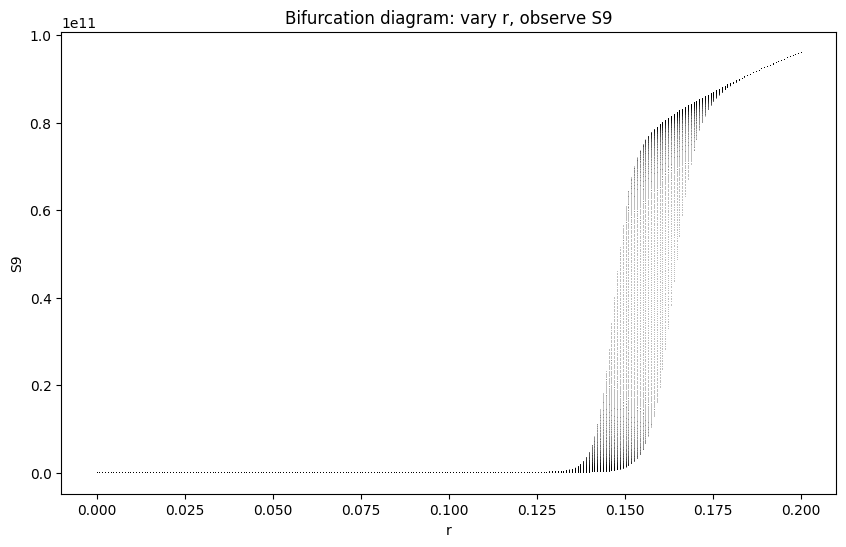

In [3]:
def bifurcation_plot(param_name="r", var_index=8, param_min=0.0, param_max=0.2, n_param=250):
    params = np.linspace(param_min, param_max, n_param)

    X_param = []
    Y_var = []

    for val in params:
        t_s, Y_s = simulate_longterm(param_name, val)
        if t_s is None:
            continue
        v = Y_s[var_index, :]   # misal S9 (index 8)
        X_param.extend([val]*len(v))
        Y_var.extend(v.tolist())

    plt.figure(figsize=(10,6))
    plt.plot(X_param, Y_var, ",k", alpha=0.25)
    plt.xlabel(param_name)
    plt.ylabel(f"S{var_index+1}")
    plt.title(f"Bifurcation diagram: vary {param_name}, observe S{var_index+1}")
    plt.show()

# Jalankan:
bifurcation_plot(param_name="r", var_index=8, param_min=0.0, param_max=0.2, n_param=250)

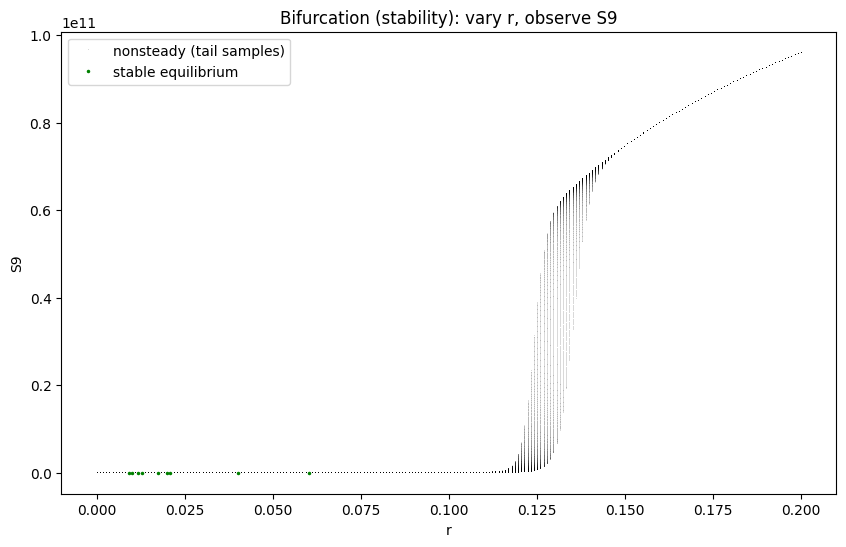

In [4]:
def jacobian_fd(y_star, p, eps=1e-6):
    y_star = np.array(y_star, dtype=float)
    n = len(y_star)
    J = np.zeros((n,n))
    f0 = f(0.0, y_star, p)
    for j in range(n):
        y2 = y_star.copy()
        y2[j] += eps
        fj = f(0.0, y2, p)
        J[:, j] = (fj - f0)/eps
    return J

def classify_stability_from_tail(param_name, val, var_index=8, tol_dyn=1e-6):
    p = par_default.copy()
    p[param_name] = float(val)

    t_s, Y_s = simulate_longterm(param_name, val, t_end=600, keep_last=120, n_sample=400)
    if t_s is None:
        return None

    # cek apakah tail "hampir konstan" (indikasi steady state)
    tail = Y_s
    y_star = np.mean(tail[:, -100:], axis=1)
    dyn = norm(f(0.0, y_star, p), ord=2)

    if dyn > tol_dyn:
        # belum steady; anggap non-steady (periodik/chaos) -> kita plot hitam saja
        return ("nonsteady", val, tail[var_index, :])

    J = jacobian_fd(y_star, p)
    lam = eigvals(J)
    stable = np.max(np.real(lam)) < 0.0
    return ("stable" if stable else "unstable", val, np.array([y_star[var_index]]))

def bifurcation_stable_unstable(param_name="r", var_index=8, param_min=0.0, param_max=0.2, n_param=220):
    params = np.linspace(param_min, param_max, n_param)

    xs_st, ys_st = [], []
    xs_un, ys_un = [], []
    xs_ns, ys_ns = [], []

    for val in params:
        out = classify_stability_from_tail(param_name, val, var_index=var_index)
        if out is None: 
            continue
        kind, x, yvals = out
        if kind == "stable":
            xs_st.extend([x]*len(yvals)); ys_st.extend(yvals.tolist())
        elif kind == "unstable":
            xs_un.extend([x]*len(yvals)); ys_un.extend(yvals.tolist())
        else:
            xs_ns.extend([x]*len(yvals)); ys_ns.extend(yvals.tolist())

    plt.figure(figsize=(10,6))
    if xs_ns:
        plt.plot(xs_ns, ys_ns, ",k", alpha=0.15, label="nonsteady (tail samples)")
    if xs_st:
        plt.plot(xs_st, ys_st, "g.", ms=3, label="stable equilibrium")
    if xs_un:
        plt.plot(xs_un, ys_un, "r.", ms=3, label="unstable equilibrium")
    plt.xlabel(param_name)
    plt.ylabel(f"S{var_index+1}")
    plt.title(f"Bifurcation (stability): vary {param_name}, observe S{var_index+1}")
    plt.legend()
    plt.show()

# Jalankan:
bifurcation_stable_unstable(param_name="r", var_index=8, param_min=0.0, param_max=0.2, n_param=220)

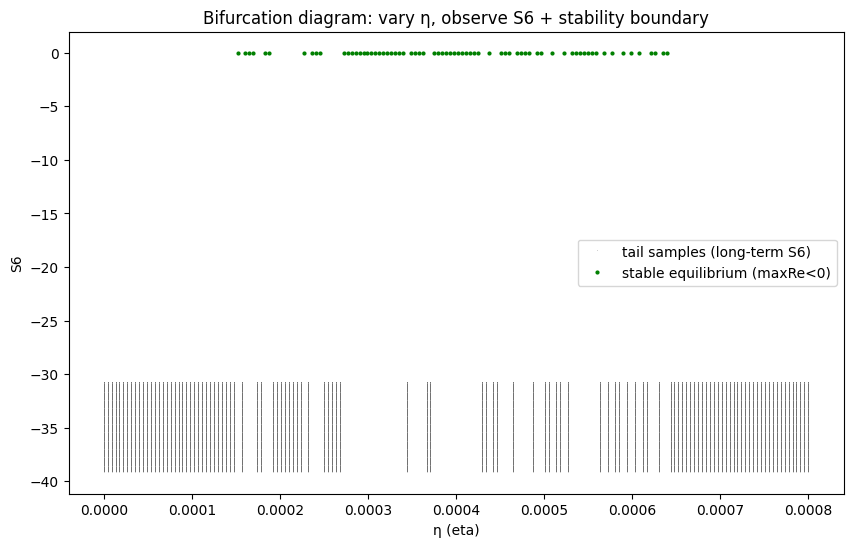

Boundary tidak terdeteksi pada rentang ini (atau steady state tidak tercapai).


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals

# pastikan fungsi ini SUDAH ADA dari sebelumnya:
# - par_default, y0
# - f(t,y,p)
# - simulate_longterm(param_name, param_value, ...)
# - jacobian_fd(y_star, p, ...)

def boundary_scan_eta(var_index=5, eta_min=0.0, eta_max=8e-4, n_eta=180):
    """
    Scan eta, cari:
    1) titik S6 tail untuk bifurkasi
    2) boundary: eta ketika maxRe(eig(J)) menyeberang 0 (stabilitas berubah)
    """
    etas = np.linspace(eta_min, eta_max, n_eta)

    # data bifurkasi (tail samples)
    X_eta, Y_s6 = [], []

    # data stabilitas (equilibrium only)
    eq_eta, eq_s6 = [], []
    maxRe_list = []   # max real part of eigenvalues at equilibrium
    steady_flag = []  # apakah dianggap steady

    for eta in etas:
        # tail untuk bifurkasi
        t_s, Y_s = simulate_longterm("eta", eta, t_end=600, keep_last=120, n_sample=350)
        if t_s is None:
            # skip jika gagal
            eq_eta.append(eta)
            eq_s6.append(np.nan)
            maxRe_list.append(np.nan)
            steady_flag.append(False)
            continue

        s6_tail = Y_s[var_index, :]
        X_eta.extend([eta]*len(s6_tail))
        Y_s6.extend(s6_tail.tolist())

        # cek steady state: gunakan rata-rata tail sebagai kandidat y*
        p = par_default.copy()
        p["eta"] = float(eta)

        y_star = np.mean(Y_s[:, -120:], axis=1)

        # apakah benar steady? lihat kedekatan ke 0 dari f(y*)
        dyn = np.linalg.norm(f(0.0, y_star, p), ord=2)

        if dyn < 1e-6:
            J = jacobian_fd(y_star, p, eps=1e-6)
            lam = eigvals(J)
            maxRe = np.max(np.real(lam))
            eq_eta.append(eta)
            eq_s6.append(y_star[var_index])
            maxRe_list.append(maxRe)
            steady_flag.append(True)
        else:
            eq_eta.append(eta)
            eq_s6.append(np.nan)
            maxRe_list.append(np.nan)
            steady_flag.append(False)

    # --- deteksi boundary: perubahan tanda maxRe (dari <0 ke >0 atau sebaliknya)
    boundaries = []
    for i in range(len(etas)-1):
        a, b = maxRe_list[i], maxRe_list[i+1]
        if np.isfinite(a) and np.isfinite(b):
            if (a < 0 and b > 0) or (a > 0 and b < 0) or (a == 0) or (b == 0):
                # interpolasi linear untuk perkiraan eta* saat maxRe=0
                eta_a, eta_b = etas[i], etas[i+1]
                if b != a:
                    eta_star = eta_a + (0 - a) * (eta_b - eta_a) / (b - a)
                else:
                    eta_star = eta_a
                boundaries.append(eta_star)

    return etas, (X_eta, Y_s6), (eq_eta, eq_s6, maxRe_list, steady_flag), boundaries


def plot_bifurcation_eta_s6_with_boundary(eta_min=0.0, eta_max=8e-4, n_eta=180):
    etas, bif, eqinfo, boundaries = boundary_scan_eta(
        var_index=5, eta_min=eta_min, eta_max=eta_max, n_eta=n_eta
    )
    X_eta, Y_s6 = bif
    eq_eta, eq_s6, maxRe_list, steady_flag = eqinfo

    plt.figure(figsize=(10,6))

    # 1) titik bifurkasi (tail sampling) - hitam
    plt.plot(X_eta, Y_s6, ",k", alpha=0.18, label="tail samples (long-term S6)")

    # 2) titik equilibrium stabil / tidak stabil (jika steady terdeteksi)
    eq_eta = np.array(eq_eta)
    eq_s6  = np.array(eq_s6)
    maxRe  = np.array(maxRe_list)

    mask = np.isfinite(eq_s6) & np.isfinite(maxRe)
    st = mask & (maxRe < 0)
    un = mask & (maxRe > 0)

    if np.any(st):
        plt.plot(eq_eta[st], eq_s6[st], "g.", ms=4, label="stable equilibrium (maxRe<0)")
    if np.any(un):
        plt.plot(eq_eta[un], eq_s6[un], "r.", ms=4, label="unstable equilibrium (maxRe>0)")

    # 3) garis boundary (vertical lines)
    for j, eta_star in enumerate(boundaries):
        plt.axvline(eta_star, linestyle="--", linewidth=1.5, color="b",
                    label="stability boundary (maxRe=0)" if j == 0 else None)

    plt.xlabel("η (eta)")
    plt.ylabel("S6")
    plt.title("Bifurcation diagram: vary η, observe S6 + stability boundary")
    plt.legend()
    plt.show()

    # Print boundary values biar jelas
    if boundaries:
        print("Perkiraan eta boundary (maxRe=0):")
        for b in boundaries:
            print(f"  eta* ≈ {b:.6e}")
    else:
        print("Boundary tidak terdeteksi pada rentang ini (atau steady state tidak tercapai).")


# Jalankan:
plot_bifurcation_eta_s6_with_boundary(eta_min=0.0, eta_max=8e-4, n_eta=180)

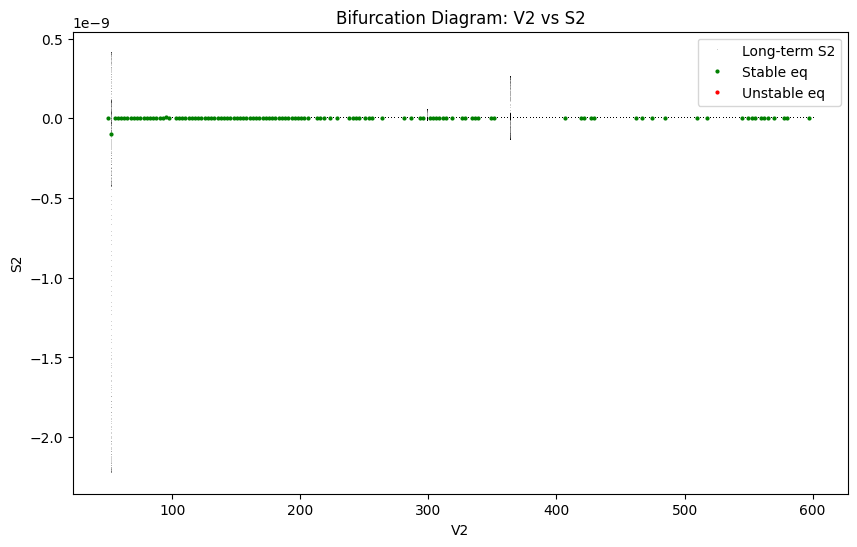

Boundary tidak ditemukan.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigvals


def boundary_scan_V2(var_index=1, V2_min=10, V2_max=800, n_V2=200):
    """
    Bifurkasi: parameter = V2
               variabel  = S2
    """
    V2_vals = np.linspace(V2_min, V2_max, n_V2)

    X_V2, Y_S2 = [], []

    eq_V2, eq_S2 = [], []
    maxRe_list = []

    for V2 in V2_vals:

        # Simulasi long-term
        t_s, Y_s = simulate_longterm(
            param_name="V2",
            param_value=V2,
            t_end=600,
            keep_last=120,
            n_sample=350
        )

        if t_s is None:
            continue

        # -----------------------
        # Data bifurkasi (tail)
        # -----------------------
        S2_tail = Y_s[var_index, :]
        X_V2.extend([V2]*len(S2_tail))
        Y_S2.extend(S2_tail.tolist())

        # -----------------------
        # Cek equilibrium
        # -----------------------
        p = par_default.copy()
        p["V2"] = float(V2)

        y_star = np.mean(Y_s[:, -120:], axis=1)

        dyn = np.linalg.norm(f(0, y_star, p), 2)

        if dyn < 1e-6:

            J = jacobian_fd(y_star, p)
            lam = eigvals(J)

            maxRe = np.max(np.real(lam))

            eq_V2.append(V2)
            eq_S2.append(y_star[var_index])
            maxRe_list.append(maxRe)

        else:
            eq_V2.append(V2)
            eq_S2.append(np.nan)
            maxRe_list.append(np.nan)

    # -----------------------
    # Deteksi boundary
    # -----------------------
    boundaries = []

    for i in range(len(maxRe_list)-1):

        a = maxRe_list[i]
        b = maxRe_list[i+1]

        if np.isfinite(a) and np.isfinite(b):

            if (a < 0 and b > 0) or (a > 0 and b < 0):

                V2a = V2_vals[i]
                V2b = V2_vals[i+1]

                V2_star = V2a + (0-a)*(V2b-V2a)/(b-a)

                boundaries.append(V2_star)

    return V2_vals, (X_V2, Y_S2), (eq_V2, eq_S2, maxRe_list), boundaries


def plot_bifurcation_V2_S2(V2_min=10, V2_max=800, n_V2=200):

    V2_vals, bif, eqinfo, boundaries = boundary_scan_V2(
        var_index=1,
        V2_min=V2_min,
        V2_max=V2_max,
        n_V2=n_V2
    )

    X_V2, Y_S2 = bif
    eq_V2, eq_S2, maxRe = eqinfo

    plt.figure(figsize=(10,6))

    # Tail samples
    plt.plot(X_V2, Y_S2, ",k", alpha=0.18,
             label="Long-term S2")

    eq_V2 = np.array(eq_V2)
    eq_S2 = np.array(eq_S2)
    maxRe = np.array(maxRe)

    mask = np.isfinite(eq_S2) & np.isfinite(maxRe)

    stable = mask & (maxRe < 0)
    unstable = mask & (maxRe > 0)

    # Stable / unstable
    plt.plot(eq_V2[stable], eq_S2[stable],
             "g.", ms=4, label="Stable eq")

    plt.plot(eq_V2[unstable], eq_S2[unstable],
             "r.", ms=4, label="Unstable eq")

    # Boundary
    for i, b in enumerate(boundaries):
        plt.axvline(b, color="b", ls="--", lw=1.5,
                    label="Stability boundary" if i==0 else None)

    plt.xlabel("V2")
    plt.ylabel("S2")
    plt.title("Bifurcation Diagram: V2 vs S2")
    plt.legend()
    plt.show()

    # Print
    if boundaries:
        print("Boundary V2* (maxRe=0):")
        for b in boundaries:
            print(f" V2* ≈ {b:.3f}")
    else:
        print("Boundary tidak ditemukan.")


# ========================
# Jalankan
# ========================
plot_bifurcation_V2_S2(
    V2_min=50,
    V2_max=600,
    n_V2=220
)


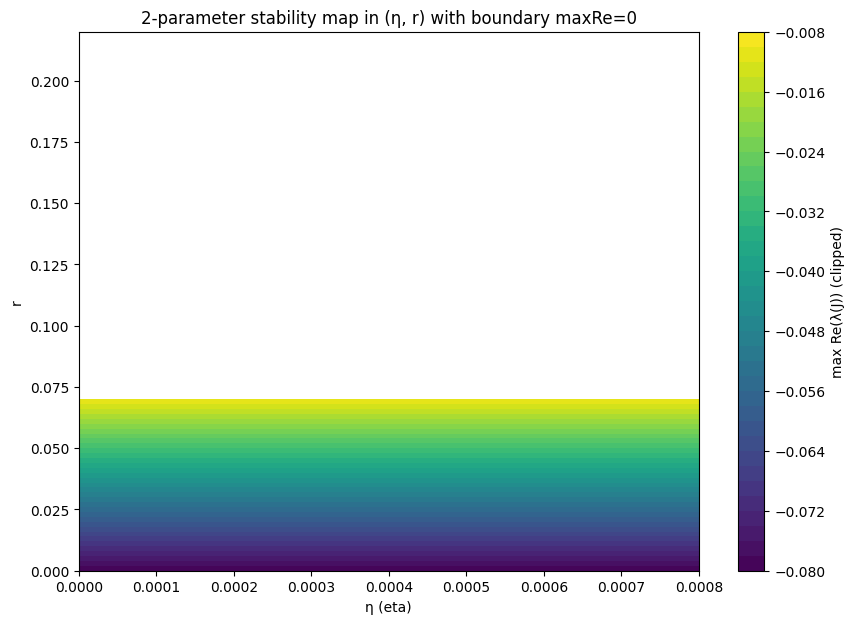

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.linalg import eigvals

# -----------------------------
# Helper: integrate + estimate equilibrium + maxRe
# -----------------------------
def integrate_tail_eta_r(eta, r, t_end=800.0, keep_last=200.0, n_eval=6000):
    """
    Integrate system for given (eta, r), return tail states.
    """
    p = par_default.copy()
    p["eta"] = float(eta)
    p["r"]   = float(r)

    t_eval = np.linspace(0.0, t_end, n_eval)
    sol = solve_ivp(lambda t, y: f(t, y, p),
                    [0.0, t_end], y0, t_eval=t_eval,
                    method="LSODA", rtol=1e-7, atol=1e-9)

    if not sol.success:
        return None, None, None

    t = sol.t
    Y = sol.y
    mask = t >= (t_end - keep_last)
    return p, t[mask], Y[:, mask]

def maxRe_at_equilibrium(eta, r, tol_dyn=1e-6):
    """
    Return maxRe eigen(J) if tail is close to equilibrium, else return np.nan.
    """
    out = integrate_tail_eta_r(eta, r)
    if out[0] is None:
        return np.nan

    p, t_tail, Y_tail = out

    # candidate equilibrium = average of last part of tail
    y_star = np.mean(Y_tail[:, -200:], axis=1)

    # check if it's really an equilibrium
    dyn = np.linalg.norm(f(0.0, y_star, p), ord=2)
    if dyn > tol_dyn:
        # non-steady (limit cycle/chaos/slow drift) -> not classified by equilibrium stability
        return np.nan

    J = jacobian_fd(y_star, p, eps=1e-6)
    lam = eigvals(J)
    return float(np.max(np.real(lam)))

# -----------------------------
# Main: compute stability map
# -----------------------------
def stability_map_eta_r(
    eta_min=0.0, eta_max=8e-4, n_eta=60,
    r_min=0.0,   r_max=0.25, n_r=60,
    tol_dyn=1e-6
):
    etas = np.linspace(eta_min, eta_max, n_eta)
    rs   = np.linspace(r_min, r_max, n_r)

    # grid of maxRe
    Z = np.full((n_r, n_eta), np.nan, dtype=float)

    for i, r in enumerate(rs):
        for j, eta in enumerate(etas):
            Z[i, j] = maxRe_at_equilibrium(eta, r, tol_dyn=tol_dyn)

    # plot
    ETA, R = np.meshgrid(etas, rs)  # shapes (n_r, n_eta)

    plt.figure(figsize=(10, 7))

    # Color map: use maxRe values (negative=stable, positive=unstable)
    # Clip for nicer visualization
    Z_clip = np.clip(Z, -0.5, 0.5)

    # show filled contour; NaNs will appear blank
    cf = plt.contourf(ETA, R, Z_clip, levels=40)
    plt.colorbar(cf, label="max Re(λ(J)) (clipped)")

    # Stability boundary: maxRe = 0
    # Only meaningful where Z is not NaN
    try:
        c0 = plt.contour(ETA, R, Z, levels=[0.0], linewidths=2)
        plt.clabel(c0, fmt={0.0: "maxRe=0"}, inline=True, fontsize=9)
    except Exception:
        pass

    plt.xlabel("η (eta)")
    plt.ylabel("r")
    plt.title("2-parameter stability map in (η, r) with boundary maxRe=0")
    plt.show()

    # Return grids for further analysis
    return etas, rs, Z

# -----------------------------
# Run (recommended ranges)
# -----------------------------
etas, rs, Z = stability_map_eta_r(
    eta_min=0.0, eta_max=8e-4, n_eta=70,
    r_min=0.0,   r_max=0.22,  n_r=70,
    tol_dyn=1e-6
)